In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import matplotlib . pyplot as plt
import torch
from transformers import ViTImageProcessor , ViTForImageClassification

In [ ]:
dataset_dir = "/content/drive/MyDrive/Project_NCKH/animals"
image_filenames = os.listdir(dataset_dir)[:500]
src_images = []

for filename in image_filenames :
    filepath = os.path.join (
        dataset_dir,
        filename
    )

    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    src_images.append(image)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
def preprocessing(images):
    inputs = processor(images, return_tensors="pt").to(device)

    model.eval()
    model.to(device)

    with torch.no_grad():
        output = model(**inputs, output_hidden_states=True).hidden_states[-1][:, 0, :].detach().cpu().numpy()

    return output

preprocessed_src_images = preprocessing(src_images)

In [ ]:
def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]

    cosine_similarity = np.dot(normalized_src, normalized_query)

    return cosine_similarity

In [ ]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k):
    scores = cosine_similarity(
        preprocessed_query_image,
        preprocessed_src_images
    )
    ranked_list = np.argsort(scores)[:: -1][: top_k]
    scores = scores[ranked_list]

    return ranked_list, scores

In [ ]:
query_image_paths = "/content/drive/MyDrive/Project_NCKH/animals/0009fc27d9.jpg"
top_k = 5

Query Image


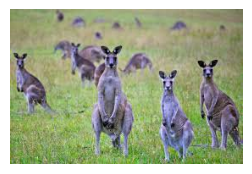

Top 5 results


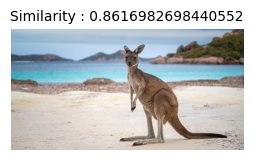

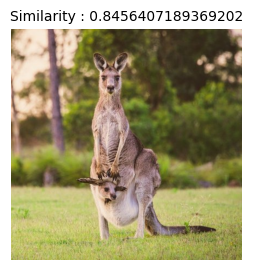

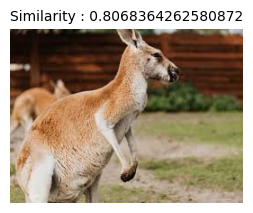

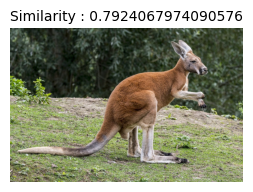

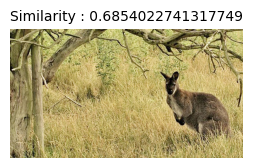

In [ ]:
query_image = cv2.imread(query_image_paths, 1)
query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
preprocessed_query_image = preprocessing(query_image).squeeze(0)

ranked_list, scores = ranking(
    preprocessed_query_image,
    preprocessed_src_images,
    top_k
)

print("Query Image")
plt.figure(figsize=(3, 3))
plt.imshow(query_image)
plt.axis("off")
plt.show()
print(f"Top {top_k} results")
for idx in range(len(ranked_list)):
    src_image_idx = ranked_list[idx]
    similarity_score = scores[idx]
    plt.figure(figsize=(3, 3))
    plt.imshow(src_images[src_image_idx])
    plt.title(f"Similarity : {similarity_score}", fontsize=10)
    plt.axis("off")
    plt.show()